In [19]:
# Install the necessary dependencies

import os
import sys 
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Long-short term memory

As we have learned the normal RNNs on the previous lessons, today we are going to use long-short term memory (LSTM) to fix the problems that are induced from the RNN architecture.

The vanilla LSTM is proposed in 2005, the paper is [Bidirectional LSTM Networks for Improved Phoneme Classification and Recognition](https://link.springer.com/chapter/10.1007/11550907_126), and after that, a lot of paper based on it appeared.


## Overview
The essential problems of RNN are vanishing/exploding gradient problems. The gradient vanishing/exploding problem is a common issue in training deep neural networks. This problem occurs when the gradient of the loss function with respect to the weights of the network becomes very small or very large.

There are several possibilities will bring on this kind of problem, for example:
- a poor choice of hyper-parameters
- a poor architecture,
- a bug in the code.

Luckily, LSTM can use a memory cell for modeling long-range dependencies and avoid vanishing/exploding gradient problems.

First, let's see the architecture of LSTM cell.

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/LSTM/LSTM_cell.png" width="90%" class="bg-white mb-1">

It looks like the cell of RNN, but there are still some differences between them. The same part is the direction of data, one input and two outputs. 
However, the LSTM cell adds a cell state $c^{<t>}$, which updates with the time. $c^{<t-1>}$ means cell state at previous time step and $c^{<t-1>}$ means cell state at current time step.
The $h^{t}$ is still the activation.

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/LSTM/cell_state.png" width="90%" class="bg-white mb-1">

## Special Gates
Then, we take a look at the inside of cell. $\bigodot$ means element-wise multiplication operator, $\bigoplus$ means element-wise addition operator and $\sigma$ means logistic sigmoid activation functions.

Now, we should pay attention to 'Gates'. 

The first is 'Forget Gate' $f$, and it controls which information is remembered, and which is forgotten; can reset the cell state. This function can be written as $f_t = \sigma (W_{fx}x^{<t>} + W_{fh}h^{<t-1>} + b_f)$

Next, 'Input Gate' is $i_t = \sigma(W_{ix}x^{<t>} + W_{ih}h^{<t-1>} + b_i)$ and 'Input Node' is $g_t = tanh(W_{gt}x^{<t>} + W_{gh}x^{<t-1>} + b_g)$.

To brief summarize the previous gates in an expression: $C^{<t>} = (C^{<t-1>} \bigodot f_t) \bigoplus (i_t \bigodot g_t)$. Since $i_t$ is 'Input Gate' and $g_t$ is 'Input Gate', $(i_t \bigodot g_t)$ is for updatting the cell state.

Finally, 'Output Gate' is for updating the values of hidden units: $o_t = \sigma(W_{ox}x^{<t>} + W_{oh}x^{<t-1>} + b_o)$. So the activateion of the current time is $h^{<t>} = o_t \bigodot tanh(C^{<t>})$.

### Code
Here we implement an LSTM model on all a data set of Shakespeare works.

In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
tf.config.run_functions_eagerly(True)

Set RNN Parameters.

In [2]:
min_word_freq = 5  # Trim the less frequent words off
rnn_size = 128  # RNN Model size
epochs = 10  # Number of epochs to cycle through data
batch_size = 100  # Train on this many examples at once
learning_rate = 0.001  # Learning rate
training_seq_len = 50  # how long of a word group to consider
embedding_size = rnn_size  # Word embedding size
save_every = 500  # How often to save model checkpoints
eval_every = 50  # How often to evaluate the test sentences
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

Download/store Shakespeare data.

In [3]:
data_dir = 'tmp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

Declare punctuation to remove, everything except hyphens and apostrophes.

In [4]:
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

Make Model Directory.

In [5]:
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)


Make data directory.

In [6]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print('Loading Shakespeare Data')

Loading Shakespeare Data


Check if file is downloaded.

In [7]:
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    # Get Shakespeare text
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    # Decode binary into string
    s_text = shakespeare_file.decode('utf-8')
    # Drop first few descriptive paragraphs.
    s_text = s_text[7675:]
    # Remove newlines
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    
    # Write to file
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    # If file has been saved, load from that file
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

Clean text.

In [8]:
print('Cleaning Text')
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text).strip().lower()

Cleaning Text


Build word vocabulary function.

In [9]:
def build_vocab(text, min_freq):
    word_counts = collections.Counter(text.split(' '))
    # limit word counts to those more frequent than cutoff
    word_counts = {key: val for key, val in word_counts.items() if val > min_freq}
    # Create vocab --> index mapping
    words = word_counts.keys()
    vocab_to_ix_dict = {key: (i_x+1) for i_x, key in enumerate(words)}
    # Add unknown key --> 0 index
    vocab_to_ix_dict['unknown'] = 0
    # Create index --> vocab mapping
    ix_to_vocab_dict = {val: key for key, val in vocab_to_ix_dict.items()}
    
    return ix_to_vocab_dict, vocab_to_ix_dict

Build Shakespeare vocabulary.

In [10]:
print('Building Shakespeare Vocab')
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))

Building Shakespeare Vocab
Vocabulary Length = 8286


Sanity Check.

In [11]:
assert(len(ix2vocab) == len(vocab2ix))

Convert text to word vectors.

In [12]:
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except KeyError:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

Define LSTM RNN Model.

In [13]:
class LSTM_Model(tf.keras.Model):
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        super(LSTM_Model, self).__init__()
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm = tf.keras.layers.LSTM(self.rnn_size, return_sequences=True, return_state=True)
        self.x_data = tf.keras.layers.Input(shape=(self.training_seq_len,), dtype=tf.int32)
        self.y_output = tf.keras.layers.Input(shape=(self.training_seq_len,), dtype=tf.int32)
        
        # Softmax Output Weights
        self.W = tf.Variable(tf.random.normal([self.rnn_size, self.vocab_size]), name='W')
        self.b = tf.Variable(tf.zeros([self.vocab_size]), name='b')
        
        # Define Embedding
        self.embedding_mat = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_size]), name='embedding_mat')
                                            
        embedding_output = tf.nn.embedding_lookup(self.embedding_mat, self.x_data)
        outputs, last_state, _ = self.lstm(embedding_output)
        
        # Non inferred outputs
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # Logits and output
        self.logit_output = tf.matmul(output, self.W) + self.b
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_fun = tf.keras.losses.sparse_categorical_crossentropy
        loss = loss_fun(tf.reshape(self.y_output, [-1]), self.logit_output)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
        @tf.function
        def train_step(x, y,state):
            with tf.GradientTape() as tape:
                embedding_output = tf.nn.embedding_lookup(self.embedding_mat, x)
                outputs, last_state, _ = self.lstm(embedding_output,initial_state=state)
                output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
                logit_output = tf.matmul(output, self.W) + self.b
                cost = tf.reduce_sum(loss_fun(tf.reshape(y, [-1]), logit_output)) / (self.batch_size * self.training_seq_len)

            trainable_variables = self.trainable_variables
            gradients = tape.gradient(cost, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            return cost
        
        self.train_op = train_step
        
    def call(self, x, initial_state):
        embedding_output = tf.nn.embedding_lookup(self.embedding_mat, x)
        lstm_output, final_state_h, final_state_c = self.lstm(embedding_output, initial_state=initial_state)
        output = tf.reshape(tf.concat(axis=1, values=lstm_output), [-1, self.rnn_size])
        logit_output = tf.matmul(output, self.W) + self.b
        model_output = tf.nn.softmax(logit_output)
        return model_output, (final_state_h, final_state_c)
    
    def loss(self, targets, logits):
        loss_fun = tf.keras.losses.sparse_categorical_crossentropy
        loss = loss_fun(targets, logits)
        return tf.reduce_mean(loss)

    def get_initial_state(self, batch_size):
        return [tf.zeros((batch_size, self.lstm.units)) for i in range(2)]
        
    def sample(self, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='art'):
        state = [tf.zeros([1, self.rnn_size]), tf.zeros([1, self.rnn_size])]
        word_list = prime_text.split()
        for word in word_list[:-1]:
            print(word)
            #x = tf.expand_dims(vocab[word], axis=0)
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            x = tf.cast(x, tf.int32)
            print(x)
            embedding_output = tf.nn.embedding_lookup(self.embedding_mat, x)
            #embedding_output = tf.expand_dims(embedding_output, axis=1)
            prediction, state_h, state_c = self.lstm(embedding_output, initial_state=state)
            state = [state_h, state_c]

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            #x = tf.expand_dims(vocab[word], axis=0)
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            x = tf.cast(x, tf.int32)
            embedding_output = tf.nn.embedding_lookup(self.embedding_mat, x)
            prediction, state_h, state_c = self.lstm(embedding_output, initial_state=state)
            logits = tf.matmul(prediction, self.W) + self.b
            sample = tf.argmax(tf.nn.softmax(logits), axis=1).numpy()[0]
            for i in sample:
                if i== 0:
                     break
                print(i)
                word = words[i]
                out_sentence = out_sentence + ' ' + word
            state = [state_h, state_c]
        return out_sentence

Define LSTM Model.

In [14]:
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                             training_seq_len, vocab_size, infer_sample=True) 

Train model.

In [15]:
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
batches = np.array_split(s_text_ix, num_batches)
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]
print(batches)
print(batch_size)
test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                             training_seq_len, vocab_size, infer_sample=True)
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
batches = np.array_split(s_text_ix, num_batches)
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]
print(batches)
print(batch_size)
train_loss = []
iteration_count = 1
state = lstm_model.get_initial_state(batch_size)
for epoch in range(epochs):
    # Shuffle word indices
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    random.shuffle(batches)
    # Create targets from shuffled batches
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # Run a through one epoch
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # Reset initial LSTM state every epoch
    #state = lstm_model.get_initial_state(batch_size)
    #state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        batch_loss = lstm_model.train_op(batch, targets[ix],state)
        train_loss.append(batch_loss)
        print('Loss = {}'.format(batch_loss))

generated_text = lstm_model.sample(words=ix2vocab, vocab=vocab2ix, num=20, prime_text='oh my')
print(generated_text)

[array([[   0,    1,    2, ...,   39,   40,   41],
       [  42,   43,   44, ...,   66,   26,   67],
       [  68,   69,   70, ...,    7,    0,   88],
       ...,
       [  62,  932,  154, ...,  219,  895,  223],
       [  10,   51,  236, ..., 1129,    2,   12],
       [   0,   61,   81, ...,    1,    2,    3]]), array([[   0,   81,  228, ...,   29,  119, 1207],
       [  23,  227,    2, ...,  557,   50,  227],
       [  17,   79,   79, ...,   18, 1235,  107],
       ...,
       [ 688,   14,   20, ...,    7,  299,  510],
       [  12,  566,   29, ...,  536,  818,   47],
       [ 398,    0,    0, ...,   81,  228,  943]]), array([[  53,  431,   23, ...,    2,  141,   51],
       [1788,   58,  555, ...,  269,  295,  337],
       [ 214, 1644,  279, ...,   85,  735,  197],
       ...,
       [ 124,  322, 2209, ...,  121,   41, 1085],
       [ 376,   21,  517, ...,   21, 2217, 2218],
       [2219,  279,  545, ...,  431,   23,   51]]), array([[ 517, 1104, 1279, ...,  409,    7,  121],
       

Plot loss over time.

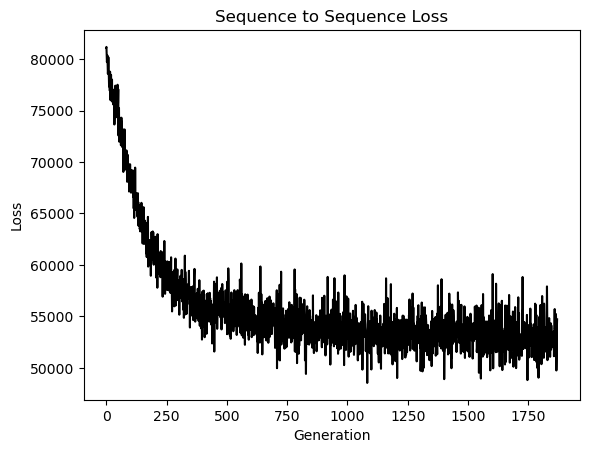

In [16]:
x = range(len(train_loss))
plt.plot(x, train_loss, 'k-')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.title('Sequence to Sequence Loss')
plt.show()

## Your turn! 🚀

Practice the Long-Short Term Memory Networks by following this TBD.

## Acknowledgments

Thanks to [Nick](https://github.com/nfmcclure) for creating the open-source project [tensorflow_cookbook](https://github.com/nfmcclure/tensorflow_cookbook) and [Sebastian Raschka](https://github.com/rasbt) for creating the open-source project [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20). They inspire the majority of the content in this chapter.